In [1]:
import pandas as pd
import numpy as np

We'll train both a Random Forest Classifier and a K-Nearest Neighbors Classifier using our menopause data. We'll then compare the two models and see which one performs better.

# 📖 Loading codebook values

### ℹ Reading in the data and variables to be used

In [2]:
menopause_data = pd.read_csv('./datasets/visit_dfs.csv', dtype='str')
menopause_data.head()

,HAVEPER,EXPENSI,BROKEBO,AGE,EXERCIS,DNTKNOW,AVCIGDA,NOREASO,SIDEEFF,OSTEOPO,...,DIETNUT,LIKEFEL,COMBIN2,BONES3,PRGNANT,SMOKERE,ESTRNJ1,STOPOTH,BONES2,HOURSPA
0,-1,-1,0,53,-9999,-1,-1,-1,-1,1,...,-9999,-1,-9999,-1,1,1,1,-1,-1,-1
1,-1,-1,0,52,-9999,-1,-1,-1,-1,-1,...,-9999,-1,-9999,-1,1,1,1,-1,-1,-1
2,-1,-1,1,46,-9999,-1,-1,-1,-1,-1,...,-9999,-1,-9999,-1,1,1,1,-1,-1,-1
3,-1,-1,0,50,-9999,-1,-1,-1,-1,-1,...,-9999,-1,-9999,-1,1,1,1,-1,-1,4
4,-1,-1,0,52,-9999,-1,-1,-1,-1,-1,...,-9999,-1,-9999,-1,1,1,1,-1,-1,-1


In [3]:
with open('./lista_variables/variables_selected_final.txt', 'r') as f:
    features = f.read().splitlines()

features

['MENODEP',
 'EXERCIS',
 'DIETNUT',
 'OUTCOME',
 'ESTRNJ2',
 'COMBIN2',
 'ESTROG2',
 'E2AVE',
 'ALCHL24',
 'ESTRDA2',
 'HOURSPA',
 'HEIGHT',
 'ESTRDA1',
 'WEIGHT',
 'HAPPY',
 'PRGNANT',
 'VAGINDR',
 'SMOKERE',
 'HOTFLAS',
 'PHYSILL',
 'AVCIGDA',
 'TRBLSLE',
 'CANCERS',
 'DIABETE',
 'BROKEBO',
 'OSTEOPR',
 'STATUS',
 'ESTROG1',
 'ESTRNJ1',
 'AGE',
 'RACE',
 'NUMHOTF',
 'VISIT']

> Do note that our variables are mainly categorical, but not all of them. We'll read a JSON file to know which variables aren't categorical and we'll change them to float.

In [4]:
menopause_data = menopause_data[features]

In [5]:
import json

with open('./lista_variables/variables_selected_labels.json', 'r') as file:
    features_labels = json.load(file)

### ✅ Parsing data to correct data type

In [6]:
integer_features = features_labels['NUMERICAL']['vars']['int']
float_features = features_labels['NUMERICAL']['vars']['float']

def parse_numbers():

    for feature in integer_features:
        menopause_data[feature] = menopause_data[feature].astype(int)

    for feature in float_features:
        menopause_data[feature] = menopause_data[feature].astype(float)

In [7]:
parse_numbers()
menopause_data.dtypes

MENODEP     object
EXERCIS     object
DIETNUT     object
OUTCOME     object
ESTRNJ2     object
COMBIN2     object
ESTROG2     object
E2AVE      float64
ALCHL24     object
ESTRDA2     object
HOURSPA     object
HEIGHT     float64
ESTRDA1     object
WEIGHT     float64
HAPPY       object
PRGNANT     object
VAGINDR     object
SMOKERE     object
HOTFLAS     object
PHYSILL     object
AVCIGDA      int32
TRBLSLE     object
CANCERS     object
DIABETE     object
BROKEBO      int32
OSTEOPR     object
STATUS      object
ESTROG1     object
ESTRNJ1     object
AGE          int32
RACE        object
NUMHOTF    float64
VISIT        int32
dtype: object

### ✨ Pipeline for negative values in data

In some of the variables, negative values are used to indicate missing data, or that the patient refused to answer. We'll create a pipeline to replace these negative values with NaNs,
and we'll use KNN to impute the missing values.

This will aid in standardizing the data.

In [8]:
numerical_features = integer_features + float_features
numerical_features.remove('VISIT')


In [9]:
# Set negatives as NaN
menopause_data[numerical_features] = menopause_data[numerical_features].apply(lambda x: x.where(x > 0, np.nan))


from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

# DONE
# menopause_data[numerical_features] = imputer.fit_transform(menopause_data[numerical_features])

In [10]:
menopause_data = pd.read_csv('./datasets/visit_dfs_imputed.csv', dtype='str')
# parse_numbers()  # Imputed values by KNN are float, so parse all as float
menopause_data[numerical_features] = menopause_data[numerical_features].astype(float)

In [11]:
menopause_data[numerical_features].isna().sum()

AVCIGDA    0
BROKEBO    0
AGE        0
NUMHOTF    0
E2AVE      0
HEIGHT     0
WEIGHT     0
dtype: int64

In [12]:
menopause_data[numerical_features].head()

,AVCIGDA,BROKEBO,AGE,NUMHOTF,E2AVE,HEIGHT,WEIGHT
0,12.4,1.0,53.0,2.8,70.15,155.4,74.0
1,20.4,1.0,52.0,2.8,194.55,161.3,53.2
2,12.2,1.0,46.0,1.8,250.65,166.1,85.6
3,17.8,1.0,50.0,2.8,187.95,161.5,78.4
4,13.2,1.0,52.0,2.2,119.50,149.5,68.0


In [13]:
# Save dataset
# DONE
# menopause_data.to_csv('./datasets/visit_dfs_imputed.csv', index=True)

# 🧠 Model training!

In [14]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from mlflow import log_metric, log_param, log_artifact, start_run


c:\Users\Admin\anaconda3\envs\LangChain\Lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\LangChain\Lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [15]:
targets = [
    'STATUS',    # Indicating if the patient is menopausal or not, among other options
    'NUMHOTF',  # Number of hot flashes daily
    'OSTEOPR',  # Indicating if the patient has osteoporosis or not
    'MENODEP',  # Indicating if the patient has depression or not
]

In [16]:
# Shuffle order to avoid order bias
menopause_data = shuffle(menopause_data)


### 👨‍⚖️ Standardizing the data

In [17]:
# Standardize numerical features
scaler = MinMaxScaler()
std_menp_data = menopause_data.copy()
std_menp_data.head()

,Unnamed: 0,MENODEP,EXERCIS,DIETNUT,OUTCOME,ESTRNJ2,COMBIN2,ESTROG2,E2AVE,ALCHL24,...,DIABETE,BROKEBO,OSTEOPR,STATUS,ESTROG1,ESTRNJ1,AGE,RACE,NUMHOTF,VISIT
1629,1629,-9999,-9999,-9999,-9999,-9999,-9999,-9999,171.150,1,...,1,1.2,1,4,1,1,47.0,4,1.4,1
7438,7438,-9999,-9999,-9999,-1,-1,-1,-1,22.095,1,...,2,1.0,1,4,1,1,52.0,4,1.6,3
21097,21097,1,2,2,-1,-1,-1,-1,30.950,1,...,1,1.0,1,2,1,1,53.0,4,2.0,9
2386,2386,-9999,-9999,-9999,-9999,-9999,-9999,-9999,93.850,1,...,1,1.2,1,5,1,1,44.0,4,2.4,1
16714,16714,-9999,-9999,-9999,-9999,-1,-1,-1,16.030,-9999,...,1,1.2,1,2,1,1,57.0,4,2.4,7


In [18]:
numerical_features_no_target = list(set(numerical_features) - set(targets))

In [19]:
std_menp_data[numerical_features_no_target] = scaler.fit_transform(menopause_data[numerical_features_no_target])
std_menp_data[numerical_features_no_target].head()

,HEIGHT,WEIGHT,AVCIGDA,BROKEBO,E2AVE,AGE
1629,0.335117,0.181293,0.169492,0.066667,0.024222,0.227273
7438,0.444975,0.262125,0.274576,0.000000,0.002884,0.454545
21097,0.314100,0.221709,0.294915,0.000000,0.004152,0.500000
2386,0.350401,0.327367,0.216949,0.066667,0.013156,0.090909
16714,0.399312,0.163395,0.322034,0.066667,0.002016,0.681818


### ⚙ Defining resources

In [20]:
# Define cross-validation rules

cv_seed = 1
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=cv_seed)

In [21]:
# Classification models
knn_classifier = KNeighborsClassifier(
    n_neighbors=5
)
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=0
)

# Define as multioutput classifier
multi_knn_classifier = MultiOutputClassifier(knn_classifier, n_jobs=-1)
multi_rf_classifier = MultiOutputClassifier(rf_classifier, n_jobs=-1)

### 🧮 Categorical values picky tuning

In [22]:
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder

def encode_labels(df: DataFrame, targets: list[str]):

    le = LabelEncoder()

    for target in targets:
        df[target] = le.fit_transform(df[target])


In [23]:
def get_hotf_category(hot_flashes: float):

    if hot_flashes <= 0 and hot_flashes < 5:
        return 1
    elif hot_flashes >= 5 and hot_flashes < 10:
        return 2
    elif hot_flashes >= 10 and hot_flashes < 15:
        return 3
    elif hot_flashes >= 15 and hot_flashes < 20:
        return 4
    elif hot_flashes >= 20 and hot_flashes < 25:
        return 5
    elif hot_flashes >= 25 and hot_flashes < 30:
        return 6
    else:
        return 7

In [24]:
# Encode categorical features for KNN model

std_menp_data_encoded = std_menp_data.copy()

# Turn 'NUMHOTF' into a categorical feature

std_menp_data_encoded['NUMHOTF'] = std_menp_data_encoded['NUMHOTF'].apply(lambda x: get_hotf_category(x))

non_numerical_features = list(set(features) - set(numerical_features))

encode_labels(std_menp_data_encoded, non_numerical_features)


In [25]:
std_menp_data_encoded[non_numerical_features] = std_menp_data_encoded[non_numerical_features].astype(int)
std_menp_data_encoded.dtypes.unique()

array([dtype('O'), dtype('int32'), dtype('float64'), dtype('int64')],
      dtype=object)

In [26]:
std_menp_data_encoded[std_menp_data_encoded == '0'].columns

Index(['Unnamed: 0', 'MENODEP', 'EXERCIS', 'DIETNUT', 'OUTCOME', 'ESTRNJ2',
       'COMBIN2', 'ESTROG2', 'E2AVE', 'ALCHL24', 'ESTRDA2', 'HOURSPA',
       'HEIGHT', 'ESTRDA1', 'WEIGHT', 'HAPPY', 'PRGNANT', 'VAGINDR', 'SMOKERE',
       'HOTFLAS', 'PHYSILL', 'AVCIGDA', 'TRBLSLE', 'CANCERS', 'DIABETE',
       'BROKEBO', 'OSTEOPR', 'STATUS', 'ESTROG1', 'ESTRNJ1', 'AGE', 'RACE',
       'NUMHOTF', 'VISIT'],
      dtype='object')

### 🏋️ Training and validating classifiers

In [27]:
models_performance = {
    'knn': {
        'model': multi_knn_classifier,
        'scores': cross_val_score(
            multi_knn_classifier,
            std_menp_data_encoded[features], 
            std_menp_data_encoded[targets],
            scoring='neg_mean_absolute_error',
            error_score='raise',
            cv=cv, 
            n_jobs=-1
        )
    },
    'rf': {
        'model': multi_rf_classifier,
        'scores': cross_val_score(
            multi_rf_classifier,
            std_menp_data_encoded[features], 
            std_menp_data_encoded[targets],
            scoring='neg_mean_absolute_error', 
            cv=cv, 
            n_jobs=-1
        )
    }

}

In [28]:
models_performance['knn']['scores']

array([-0.07473519, -0.0733621 , -0.07218517, -0.0742448 , -0.0715967 ,
       -0.07355826, -0.07708905, -0.07260597, -0.07348901, -0.07574568,
       -0.07650059, -0.07395057, -0.07375441, -0.06953707, -0.07522558,
       -0.079541  , -0.07395057, -0.07211538, -0.07211538, -0.07486264,
       -0.06865437, -0.0760102 , -0.07826599, -0.08052177, -0.06894861,
       -0.07091016, -0.07326403, -0.07751177, -0.07211538, -0.0788854 ])

In [29]:
n_scores = np.absolute(models_performance['knn']['scores'])
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.074 (0.003)


In [30]:
n_scores = np.absolute(models_performance['rf']['scores'])
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.004 (0.001)


### 📊 Comparing classifiers

In [31]:
# Import matplotlib, python's plotting library.
import matplotlib.pyplot as plt

In [35]:
# Get the MAE and standard deviation of the scores.
mae_knn = np.absolute(models_performance['knn']['scores'])
mae_rf = np.absolute(models_performance['rf']['scores'])
mae_knn_mean = np.mean(mae_knn)
mae_rf_mean = np.mean(mae_rf)
mae_knn_std = np.std(mae_knn)
mae_rf_std = np.std(mae_rf)
print('KNN MAE: %.3f (%.3f)' % (mae_knn_mean, mae_knn_std))
print('RF MAE: %.3f (%.3f)' % (mae_rf_mean, mae_rf_std))

KNN MAE: 0.074 (0.003)
RF MAE: 0.004 (0.001)


In [36]:
# Define the model names.
model_names = ['KNN', 'RF']

In [37]:
# Save the MAE of the models in a list.
model_mae = [mae_knn_mean, mae_rf_mean]
# Save the standard deviation of the models in a list.
model_std = [mae_knn_std, mae_rf_std]

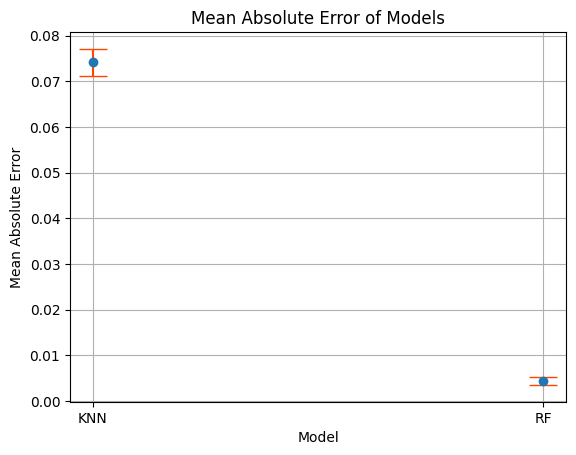

In [39]:
# Create an error bar for each model.
plt.errorbar(model_names, model_mae, yerr=model_std, fmt='o', ecolor='orangered', capsize=10)

# Title and labels.
plt.title('Mean Absolute Error of Models')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')

# Show grid.
plt.grid(True)

# Show plot.
plt.show()